In [80]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [1]:
%reload_ext autoreload
%autoreload 2

# DAMLAS - Machine Learning At Scale
## Assignment - HW3
Data Analytics and Machine Learning at Scale
Target, Minneapolis

---
__Name:__  Thomas Hughes   
__Class:__ DAMLAS (Section Summer 2016)     
__Email:__  Thomas.Hughes@Target.com     
__Week:__   03

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 08/02/2016 at 11AM (CT).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](http://goo.gl/forms/er3OFr5eCMWDngB72)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---
* [Slides for Supervised-ML-Classification-via-GradientDescent](https://www.dropbox.com/s/uzoch1dwft8kaqw/Lecture-15-Supervised-ML-Classification-via-GradientDescent.pdf?dl=0)
* [Slides from High Entropy Friday]( https://www.dropbox.com/s/0dlvsff3660vvbk/Lecture-High-Entropy-Friday.pdf?dl=0)

---

<a name="HW3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="3.0"></a><h2 style="color:darkblue"> HW3.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

*Apache Spark is a cluster-computing framework.  It is different from Hadoop in a couple ways.  First, Spark does not have a distributed file system like HDFS.  Rather, Spark relies on other file systems to read and store data.  Second, Spark makes more efficient use of memory versus Hadoop.  Spark caches information which makes calling that data much faster.  Third, Spark easily interfaces with the languages listed below making it much easier to learn than Hadoop

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, ___ BLANKS __ languages (list languages). __

*Java, Scala, Python and R*

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or ????? in a distributed manner. __

*YARN*  
*Spark also has its own "standalone" cluster manager*

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

*A RDD is a Resilient Distributed Dataset.  It is the "backbone" of Spark. It is set up with partitions allowing for distributed computing within a cluster. The example is below*
<hr>


In [2]:
import os
import sys #current as of 9/26/2015

spark_home = os.environ['SPARK_HOME'] = 'c:/Apps/Spark/Spark_1.6.2/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))


import pyspark
from pyspark.sql import SQLContext

app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print(sc)
print(sqlContext)


# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

In [2]:
rdd = sc.parallelize(["Teenage",  "Mutant", "Ninja",  "Turtles", 
                      "Teenage",  "Mutant", "Ninja",  "Turtles", 
                      "Heroes", "In", "A", "Half-Shell", "Turtle", "Power"], 5)

rdd.first()

'Teenage'

<a name="HW3.1"> <h2 style="color:darkgreen">HW3.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [106]:
import sys, re, string, operator

def removePunctuation(text):
    """Removes punctuation, changes to lowercase, and strips leading and trailing spaces.
    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated. (e.g. it's becomes its)
    Args:
        text (str): A string.
    Returns:
        str: The cleaned up string.
    """
    return re.sub('[^a-z| |0-9]', '', text.strip().lower())

wc = (sc.textFile('HW3.txt').map(removePunctuation))


counts = wc.flatMap(lambda line: line.split(" ")) \
             .filter(lambda word: word != '') \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a: (a[1], a[0]), 0)
wordCounts = counts.collect()

print "Top 20 words:" + str(wordCounts[:20])

print "Bottom 10 words:" + str(wordCounts[-10:])



Top 20 words:[(u'the', 75), (u'of', 50), (u'and', 40), (u'in', 34), (u'to', 33), (u'a', 24), (u'code', 21), (u'this', 17), (u'table', 17), (u'kmeans', 17), (u'here', 17), (u'for', 17), (u'contents', 17), (u'back', 17), (u'with', 16), (u'data', 16), (u'notebook', 15), (u'using', 14), (u'plot', 14), (u'as', 14)]
Bottom 10 words:[(u'31', 1), (u'2nd', 1), (u'2hw', 1), (u'2016', 1), (u'2009', 1), (u'1||x||', 1), (u'1hw', 1), (u'11am', 1), (u'08022016', 1), (u'03', 1)]


In [83]:
## Drivers & Runners

In [84]:
## Run Scripts, S3 Sync

<a name="HW3.1.1"><h2 style="color:darkgreen">HW3.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [167]:
import sys, re, string, operator

def removePunctuation(text):
    """Removes punctuation, changes to lowercase, and strips leading and trailing spaces.
    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated. (e.g. it's becomes its)
    Args:
        text (str): A string.
    Returns:
        str: The cleaned up string.
    """
    return re.sub('[^a-z| A-Z |0-9]', '', text.strip())


                  
def remove_upper(s):
    return re.sub(r'(\A)[^a-z]\w+', r'\1', s)

wc = sc.textFile('HW3.txt').map(removePunctuation)


counts = wc.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: remove_upper(word)) \
             .map(lambda word: re.sub(r'(\A)[^a-z]', r'\1', word)) \
             .filter(lambda word: word != '') \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a: (a[1], a[0]), 0)
wordCounts = counts.collect()

for i in wordCounts:
    print i



(u'the', 71)
(u'of', 49)
(u'and', 40)
(u'to', 33)
(u'in', 32)
(u'a', 23)
(u'this', 17)
(u'for', 17)
(u'with', 16)
(u'data', 14)
(u'as', 14)
(u'plot', 12)
(u'notebook', 12)
(u'model', 12)
(u'here', 12)
(u'code', 12)
(u'is', 10)
(u'goes', 9)
(u'your', 8)
(u'space', 8)
(u'regression', 8)
(u'on', 7)
(u'linear', 7)
(u'iteration', 7)
(u'from', 7)
(u'following', 7)
(u'each', 7)
(u'using', 6)
(u'provided', 6)
(u'one', 6)
(u'iterations', 6)
(u'it', 6)
(u'domain', 6)
(u'clusters', 6)
(u'words', 5)
(u'training', 5)
(u'plots', 5)
(u'x', 4)
(u'submissions', 4)
(u'side', 4)
(u'set', 4)
(u'notebooks', 4)
(u'more', 4)
(u'function', 4)
(u'frequent', 4)
(u'efficient', 4)
(u'at', 4)
(u'above', 4)
(u'that', 3)
(u'submission', 3)
(u'show', 3)
(u'should', 3)
(u'results', 3)
(u'report', 3)
(u'referenced', 3)
(u'questions', 3)
(u'or', 3)
(u'most', 3)
(u'master', 3)
(u'list', 3)
(u'learning', 3)
(u'just', 3)
(u'into', 3)
(u'incorporate', 3)
(u'import', 3)
(u'homegrown', 3)
(u'findings', 3)
(u'example', 3)
(u'd

In [168]:
## Drivers & Runners

In [87]:
## Run Scripts, S3 Sync

<a name="HW3.2"> <h2 style="color:darkblue"> HW3.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [4]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
import shutil
import os


 

data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

x = clusters.clusterCenters

y = parsedData.collect()

print x
print y

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))


if os.path.exists('myModelPath') == True:
    shutil.rmtree('myModelPath')

clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")



[array([ 9.1,  9.1,  9.1]), array([ 0.1,  0.1,  0.1])]
[array([ 0.,  0.,  0.]), array([ 0.1,  0.1,  0.1]), array([ 0.2,  0.2,  0.2]), array([ 9.,  9.,  9.]), array([ 9.1,  9.1,  9.1]), array([ 9.2,  9.2,  9.2])]
Within Set Sum of Squared Error = 0.692820323028


<a name="HW3.3"><h2 style="color:darkgreen"> HW3.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



In [4]:
%matplotlib inline
import numpy as np
from math import sqrt
import pylab 
import json

In [5]:
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

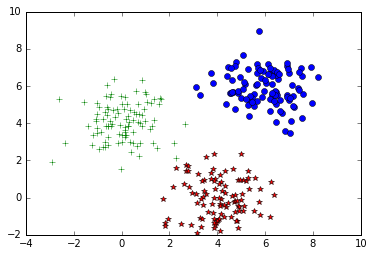

In [6]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [7]:
#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

In [19]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

clusters = None
iter_num = 0
iter_data = []
WSSSE = []
data = sc.textFile("data.csv")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')])).cache()

for i in range(100):
# Build the model (cluster the data)
    clusters = KMeans.train(parsedData, 3, maxIterations=i,
        runs=1, initializationMode="random")
    WSSSE_mllib = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
        #print("Within Set Sum of Squared Error = " + str(wssse))
    iter_data.append([iter_num, clusters.clusterCenters, WSSSE_mllib])
    #plot_iteration(centroids)
    iter_num = iter_num + 1

    



Iteration0
[array([ 3.77055162, -0.35286185]), array([ 3.90446295,  0.45538387]), array([-0.09094977,  3.39273999])]
Within Set Sum of Squared Error = 833.567046836


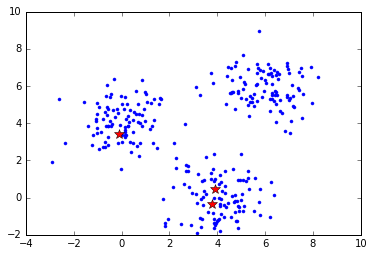

Iteration9
[array([ 0.02521319,  4.10241521]), array([ 5.97943386,  5.90759386]), array([ 4.04848875,  0.01226935])]
Within Set Sum of Squared Error = 379.648572828


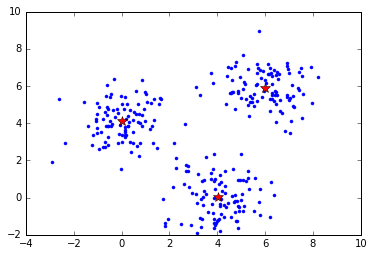

Iteration19
[array([ 5.97943386,  5.90759386]), array([ 0.02521319,  4.10241521]), array([ 4.04848875,  0.01226935])]
Within Set Sum of Squared Error = 379.648572828


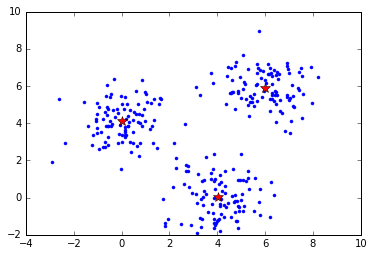

Iteration99
[array([ 0.02521319,  4.10241521]), array([ 4.04848875,  0.01226935]), array([ 5.97943386,  5.90759386])]
Within Set Sum of Squared Error = 379.648572828


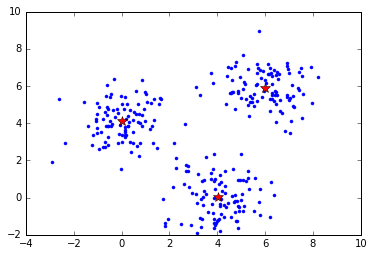

Final Results:
[array([ 0.02521319,  4.10241521]), array([ 4.04848875,  0.01226935]), array([ 5.97943386,  5.90759386])]
Within Set Sum of Squared Error = 379.648572828


In [20]:
plot_list = [0, 9, 19, 99]

for i in iter_data:
    if i[0] in plot_list:
        print "Iteration" + str(i[0])
        print i[1]
        print("Within Set Sum of Squared Error = " + str(i[2]))
        plot_iteration(i[1])


print "Final Results:"
print clusters.clusterCenters
print("Within Set Sum of Squared Error = " + str(WSSSE_mllib)) 

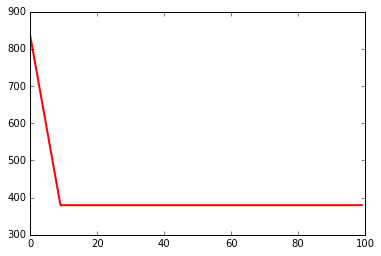

In [21]:
wssse_list = [0, 9, 19, 29, 39, 49, 99]
pl_x = []
pl_y = []
for i in iter_data:
    if i[0] in wssse_list:
        pl_x.append(i[0])
        pl_y.append(i[2])
        
pylab.plot(pl_x, pl_y,linewidth=2.0, color = 'red')

pylab.show()

#### The code runs fine.  It appears that by 10 iterations it has reached the minimum error.  Since mllib is designed to to the looping for you the code above seems like a waste of time versus just having mllib kmeans compute the final cluster centers.

<a name="HW3.4"><h2 style="color:darkblue"> HW3.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW3.3. Explain any differences between the results in HW3.3 and HW3.4. 

In [8]:
from numpy import array
from math import sqrt
#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    #print centroids[closest_centroid_idx]
    return (closest_centroid_idx,(x,1))


def error(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    err = sqrt(np.sum((x-centroids[closest_centroid_idx])**2))
    return (closest_centroid_idx, err)
#I am not calculating the square root because that is not part of the formula according to stack overflow


In [9]:
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])


D = sc.textFile("data.csv").cache()

iter_num = 0
iter_data = []
for i in range(100):  
    err = D.map(error).reduceByKey(lambda x,y: x+y).collect()   
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    wssse = 0
    for i in err:
        wssse += i[1]
    #if np.sum(np.absolute(centroids_new-centroids))<0.01:
    #    break
    #print "Iteration" + str(iter_num)
    centroids = centroids_new
    #print centroids
    #print("Within Set Sum of Squared Error = " + str(wssse))
    iter_data.append([iter_num, centroids, wssse])
    #plot_iteration(centroids)
    iter_num = iter_num + 1

   





Iteration0
[[ 0.77468493  0.28549242]
 [ 4.05403659  2.6342227 ]
 [ 2.04199662  5.64363657]]
Within Set Sum of Squared Error = 1086.89823665


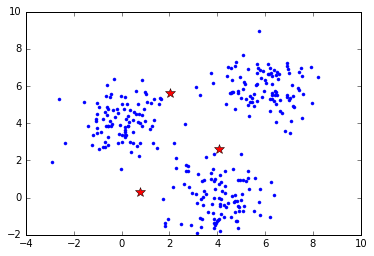

Iteration9
[[ 4.04848875  0.01226935]
 [ 5.97943386  5.90759386]
 [ 0.02521319  4.10241521]]
Within Set Sum of Squared Error = 379.648572828


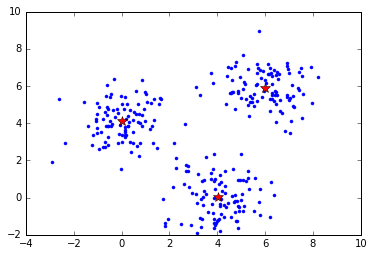

Iteration19
[[ 4.04848875  0.01226935]
 [ 5.97943386  5.90759386]
 [ 0.02521319  4.10241521]]
Within Set Sum of Squared Error = 379.648572828


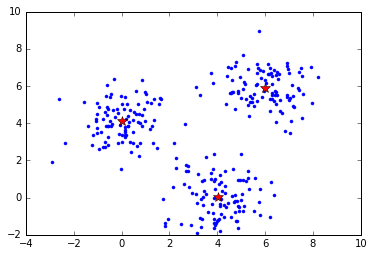

Iteration99
[[ 4.04848875  0.01226935]
 [ 5.97943386  5.90759386]
 [ 0.02521319  4.10241521]]
Within Set Sum of Squared Error = 379.648572828


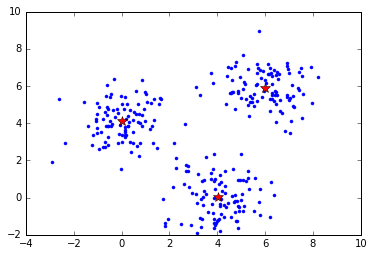

Final Results:
[[ 4.04848875  0.01226935]
 [ 5.97943386  5.90759386]
 [ 0.02521319  4.10241521]]
Within Set Sum of Squared Error = 379.648572828


In [11]:
plot_list = [0, 9, 19, 99]

for i in iter_data:
    if i[0] in plot_list:
        print "Iteration" + str(i[0])
        print i[1]
        print("Within Set Sum of Squared Error = " + str(i[2]))
        plot_iteration(i[1])


print "Final Results:"
print centroids
print("Within Set Sum of Squared Error = " + str(wssse)) 

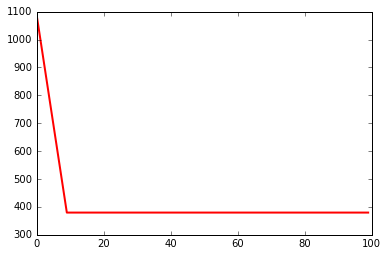

In [18]:
wssse_list = [0, 9, 19, 29, 39, 49, 99]
pl_x = []
pl_y = []
for i in iter_data:
    if i[0] in wssse_list:
        pl_x.append(i[0])
        pl_y.append(i[2])
        
pylab.plot(pl_x, pl_y,linewidth=2.0, color = 'red')

pylab.show()

I get the same WSSSE in the KMeans mllib model and in the homegrown model.  The mllib model runs faster, but does not appear to provide visibility to each iteration

<a name="HW3.4.1"><h2 style="color:darkblue"> HW3.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

In [14]:
testRDD = sc.textFile("data.csv",1)

In [15]:
import numpy as np
from math import sqrt
plot_list = [0, 9, 19, 99]



def kmeans(data,initial=None,iterations=100):
    RDD = data.map(lambda row: map(lambda x: float(x), row.split(","))).cache()
    if initial is None:
        ctr = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])
    else:
        ctr = initial
    
    for i in range(iterations):
        centroid_broad = sc.broadcast(ctr)
        closest_centroid = RDD.map(lambda x: (np.sum((x - centroid_broad.value)**2, axis=1).argmin(), x)) 
        centroid_count = closest_centroid.countByKey() 
        agg_centroid = closest_centroid.reduceByKey(lambda a, b: [a[0]+b[0],a[1]+b[1]]).collect()
        new_centroid = np.array([np.array(x[1])/centroid_count[x[0]] for x in agg_centroid])
        wssse = closest_centroid.map(lambda x: (0,sqrt(np.sum((x[1]-centroid_broad.value[x[0]])**2)))).reduceByKey(lambda a, b: a+b).collect()
        ctr = new_centroid
        if i in plot_list:
            print "Round: " + str(i)
            print "New Centroids: " + str(ctr)
            print "WSSSE: " + str(wssse[0][1])
            plot_iteration(ctr)
            


Round: 0
New Centroids: [[ 0.77468493  0.28549242]
 [ 4.05403659  2.6342227 ]
 [ 2.04199662  5.64363657]]
WSSSE: 1086.89823665


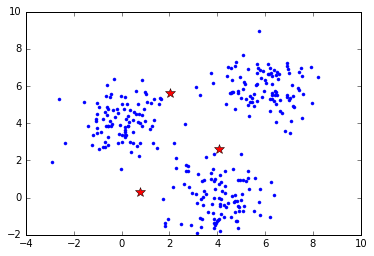

Round: 9
New Centroids: [[ 4.04848875  0.01226935]
 [ 5.97943386  5.90759386]
 [ 0.02521319  4.10241521]]
WSSSE: 379.648572828


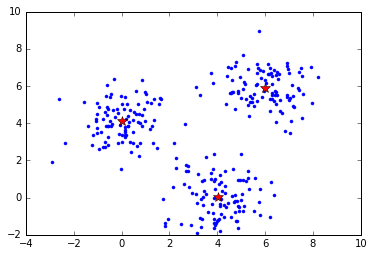

Round: 19
New Centroids: [[ 4.04848875  0.01226935]
 [ 5.97943386  5.90759386]
 [ 0.02521319  4.10241521]]
WSSSE: 379.648572828


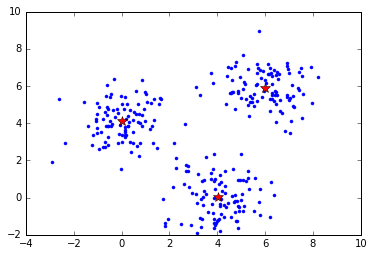

Round: 99
New Centroids: [[ 4.04848875  0.01226935]
 [ 5.97943386  5.90759386]
 [ 0.02521319  4.10241521]]
WSSSE: 379.648572828


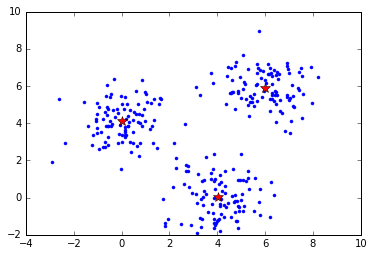

In [16]:
kmeans(testRDD)

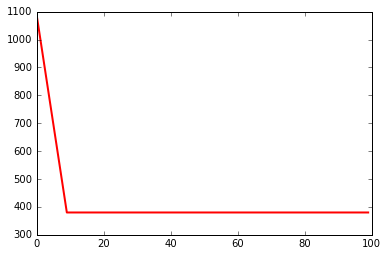

In [17]:

pl_x = [0, 9, 19, 99]
pl_y = [1087, 380, 380, 380]

        
pylab.plot(pl_x, pl_y,linewidth=2.0, color = 'red')

pylab.show()

#### The updated code runs faster than my code in 3.3.  I make more efficient use of the reducer in my code for 3.4, meaning more straightforward code.  It can be further improved by adding a code to break when the centroids stop changing, but I left that out as the homework specifies 100 runs

<a name="HW3.5"><h2 style="color:darkgreen"> HW3.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW3.3. Explain  any differences between the results in HW3.3 and HW3.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [100]:
## Code goes here

In [101]:
## Drivers & Runners

In [102]:
## Run Scripts, S3 Sync

<a name="HW3.6"><h2 style="color:darkblue"> HW3.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW3.6.1"><h2 style="color:darkblue"> HW3.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


<a name="HW3.6.2"><h2 style="color:darkblue"> HW3.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from 3.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [103]:
## Code goes here

In [104]:
## Drivers & Runners

In [105]:
## Run Scripts, S3 Sync

<a name="HW3.7"><h2 style="color:darkgreen"> HW3.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [3]:
## Code goes here

In [107]:
## Drivers & Runners

In [108]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>